In [1]:
import warnings
import numpy as np
import xarray as xr
from numba import jit
import proplot as pplt
from matplotlib.lines import Line2D
pplt.rc['tick.minor']=False
warnings.filterwarnings('ignore')

In [2]:
FILEDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed'
SAVEDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/figs'
REGIONS = {
    'Eastern Arabian Sea':{'latmin':9.,'latmax':19.5,'lonmin':64.,'lonmax':72.}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Central Bay of Bengal':{'latmin':9.,'latmax':14.5,'lonmin':86.5,'lonmax':90.},
    'Equatorial Indian Ocean':{'latmin':5.,'latmax':10.,'lonmin':62.,'lonmax':67.5},
    'Konkan Coast':{'latmin':15.,'latmax':19.5,'lonmin':69.,'lonmax':72.5}} 
BINPARAMS = {
    'bl':{'min':-0.6,'max':0.1,'width':0.0025},
    'cape':{'min':-70.,'max':20.,'width':1.},
    'subsat':{'min':-20.,'max':70.,'width':1.}}
MONTHPAIRS    = [(6,7),(7,8)]
SAMPLETHRESH  = 50
NITERATIONS   = 1000
YEARSINSAMPLE = 5
CONFIDENCE    = 0.95

In [3]:
def load(filename,filedir=FILEDIR,varlist=None):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    if varlist:
        ds = ds[varlist]
    return ds.load()

In [4]:
hrimergprbl = load('LR_ERA5_IMERG_pr_bl_terms.nc',varlist=['pr','bl'])
lrimergprbl = load('LR_ERA5_IMERG_pr_bl_terms.nc',varlist=['pr','bl'])
lrgpcpprbl  = load('LR_ERA5_GPCP_pr_bl_terms.nc',varlist=['pr','bl'])

 Use ```calc_actual_pr_diffs()``` to calculate the actual and predicted precipitation differences for each subregion.

Use bootstrapping to estimate the uncertainty around these actual differences. Bootstrapping involves: a. Repeatedly resampling your data with replacement b. Calculating the statistic of interest (in this case, precipitation differences) for each resampled dataset c. Using the distribution of these bootstrap statistics to estimate the uncertainty of your actual statistic

Calculate the 95% confidence interval from the bootstrap distribution. This gives you the "error bars" to apply to your actual precipitation differences.

In [5]:
def get_region(data,key,regions=REGIONS):
    region = regions[key]
    return data.sel(lat=slice(region['latmin'],region['latmax']),lon=slice(region['lonmin'],region['lonmax']))

def get_month(data,months):
    if not isinstance(months,(list,tuple)):
        months = [months]
    monthmask = data.time.dt.month.isin(months)
    return data.sel(time=monthmask)

def get_bin_edges(key,binparams=BINPARAMS):
    varname  = binparams[key]
    binedges = np.arange(varname['min'],varname['max']+varname['width'],varname['width'])
    return binedges
    
@jit(nopython=True)
def fast_1D_binned_stats(bl,pr,blbinmin,blbinwidth,nblbins):
    Q0 = np.zeros(nblbins)
    Q1 = np.zeros(nblbins)
    blidxs = ((bl-blbinmin)/blbinwidth+0.5).astype(np.int32)
    for i in range(bl.size):
        blidx = blidxs.flat[i]
        prval = pr.flat[i]
        if 0<=blidx<nblbins and np.isfinite(prval):
            Q0[blidx] += 1
            Q1[blidx] += prval
    return Q0,Q1

def calc_1D_binned_stats(data,binparams=BINPARAMS):
    blbins  = get_bin_edges('bl',binparams)
    nblbins = blbins.size
    blbinmin   = binparams['bl']['min']
    blbinwidth = binparams['bl']['width']
    Q0,Q1 = fast_1D_binned_stats(data.bl.values,data.pr.values,blbinmin,blbinwidth,nblbins)
    ds = xr.Dataset(data_vars={'Q0':(('bl'),Q0),'Q1':(('bl'),Q1)},coords={'bl':blbins})
    ds.Q0.attrs = dict(long_name='Count of points in each bin')
    ds.Q1.attrs = dict(long_name='Sum of precipitation in each bin',units='mm/day')
    ds.bl.attrs = dict(long_name='Average buoyancy in the lower troposphere', units='m/s²')
    return ds

def get_bootstrap_samples(data,niterations=NITERATIONS,yearsinsample=YEARSINSAMPLE):
    allyears = np.unique(data.time.dt.year.values)
    nyears   = len(allyears)
    yearidxs = np.random.choice(nyears,size=(niterations,yearsinsample),replace=True)
    samples = []
    for iterationidxs in yearidxs:
        selectedyears = allyears[iterationidxs]
        sample = data.sel(time=data.time.dt.year.isin(selectedyears))
        samples.append(sample)
    return samples

def calc_actual_monthly_pr(monthdata):
    return monthdata.pr.mean(dim=['lat','lon','time']).values
        
def calc_predicted_monthly_pr(monthstats,regionstats,samplethresh=SAMPLETHRESH):
    blpdf     = (monthstats.Q0/np.nansum(monthstats.Q0)).where(monthstats.Q0>=samplethresh)
    binmeanpr = (regionstats.Q1/regionstats.Q0).where(regionstats.Q0>=samplethresh)
    return np.nansum(blpdf*binmeanpr)

def calc_regional_pr_diffs(regiondata,monthpair,binparams=BINPARAMS,samplethresh=SAMPLETHRESH):
    realmonthprlist = []
    predmonthprlist = []
    regionstats = calc_1D_binned_stats(regiondata,binparams)
    for month in monthpair:
        monthdata  = get_month(regiondata,month)
        monthstats = calc_1D_binned_stats(monthdata,binparams)
        realmonthprlist.append(calc_actual_monthly_pr(monthdata))
        predmonthprlist.append(calc_predicted_monthly_pr(monthstats,regionstats,samplethresh))
    realprdiff = realmonthprlist[1]-realmonthprlist[0]
    predprdiff = predmonthprlist[1]-predmonthprlist[0]
    return realprdiff,predprdiff

def calc_actual_pr_diffs(data,regions=REGIONS,monthpairs=MONTHPAIRS,binparams=BINPARAMS,samplethresh=SAMPLETHRESH):
    realprdifflist = []
    predprdifflist = []
    for i,region in enumerate(regions):
        monthpair  = monthpairs[0] if i<3 else monthpairs[1]
        regiondata = get_month(get_region(data,region),monthpair)
        realprdiff,predprdiff = calc_regional_pr_diffs(regiondata,monthpair,binparams,samplethresh)
        realprdifflist.append(realprdiff)
        predprdifflist.append(predprdiff)
    return (xr.DataArray(realprdifflist,dims=['region'],coords={'region':list(regions.keys())}),
            xr.DataArray(predprdifflist,dims=['region'],coords={'region':list(regions.keys())}))

def calc_bootstrap_pr_diffs(data,niterations=NITERATIONS,yearsinsample=YEARSINSAMPLE,regions=REGIONS,
                            monthpairs=MONTHPAIRS,binparams=BINPARAMS,samplethresh=SAMPLETHRESH):
    realprdiffensemble = []
    predprdiffensemble = []
    for i,region in enumerate(regions):
        monthpair  = monthpairs[0] if i<3 else monthpairs[1]
        regiondata = get_month(get_region(data,region),monthpair)
        samples    = get_bootstrap_samples(regiondata,niterations,yearsinsample)
        realprdiffsamples = []
        predprdiffsamples = []
        for sample in samples:
            realprdiff,predprdiff = calc_regional_pr_diffs(sample,monthpair,binparams,samplethresh)
            realprdiffsamples.append(realprdiff)
            predprdiffsamples.append(predprdiff)
        realprdiffensemble.append(realprdiffsamples)
        predprdiffensemble.append(predprdiffsamples)
    return (xr.DataArray(realprdiffensemble,dims=['region','iteration'],coords={'region':list(regions.keys())}),
            xr.DataArray(predprdiffensemble,dims=['region','iteration'],coords={'region':list(regions.keys())}))

def get_confidence_intervals(actualvalues,bootstrapensemble,confidence=CONFIDENCE):
    actualdiff = bootstrapensemble-actualvalues
    lowerpercentile = (1-confidence)/2
    upperpercentile = 1-lowerpercentile
    cilower = actualvalues-actualdiff.quantile(upperpercentile,dim='iteration')
    ciupper = actualvalues-actualdiff.quantile(lowerpercentile,dim='iteration')
    return cilower,ciupper
    
def get_pr_diff_with_error(data,regions=REGIONS,monthpairs=MONTHPAIRS,binparams=BINPARAMS,samplethresh=SAMPLETHRESH,
                           niterations=NITERATIONS,yearsinsample=YEARSINSAMPLE,confidence=CONFIDENCE):
    real,pred = calc_actual_pr_diffs(data,regions,monthpairs,binparams,samplethresh)
    realbootstrap,predbootstrap = calc_bootstrap_pr_diffs(data,niterations,yearsinsample,regions,monthpairs,binparams,samplethresh)
    realcilower,realciupper = get_confidence_intervals(real,realbootstrap)
    predcilower,predciupper = get_confidence_intervals(pred,predbootstrap)
    realyerr = xr.concat([real-realcilower,realciupper-real],dim='ci')
    predyerr = xr.concat([pred-predcilower,predciupper-pred],dim='ci')
    return real,realyerr,pred,predyerr

In [6]:
hrimergreal,hrimergrealyerr,hrimergpred,hrimergpredyerr = get_pr_diff_with_error(hrimergprbl) 
lrimergreal,lrimergrealyerr,lrimergpred,lrimergpredyerr = get_pr_diff_with_error(lrimergprbl) 
lrgpcpreal,lrgpcprealyerr,lrgpcppred,lrgpcppredyerr     = get_pr_diff_with_error(lrgpcpprbl)  

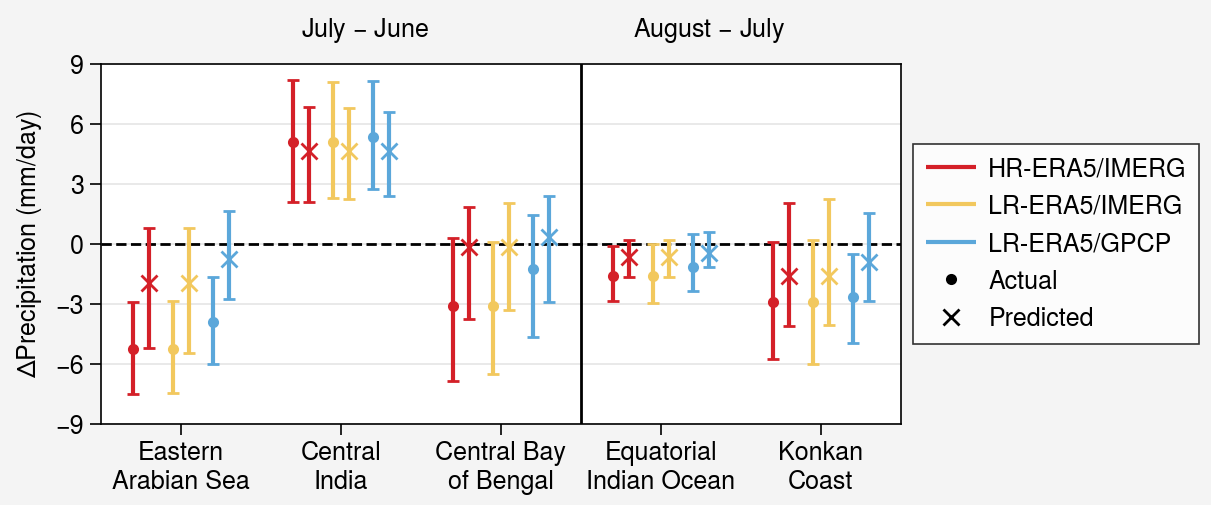

In [8]:
def create_plot(datadict,filename=None):
    reallist     = [item[0] for item in datadict]
    realyerrlist = [item[1] for item in datadict]
    predlist     = [item[2] for item in datadict]
    predyerrlist = [item[3] for item in datadict]
    namelist     = [item[4] for item in datadict]    
    regions  = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
    colors   = ['#D42028','#F2C85E','#5BA7DA']
    offsets  = [-0.25,0,0.25]
    fig,ax   = pplt.subplots(refheight=1.8,refwidth=4)
    ax.format(xlim=(-0.5,len(regions)-0.5),xticks=range(len(regions)),xticklabels=regions,grid=False,ygrid=True,
              ylabel='$\Delta$Precipitation (mm/day)',ylim=(-9,9),yticks=3)
    ax.text(x=1.15,y=ax.get_ylim()[1]+1,s='July $-$ June',ha='center',va='bottom')
    ax.text(x=3.3,y=ax.get_ylim()[1]+1,s='August $-$ July',ha='center',va='bottom')
    ax.axvline(x=2.5,color='k',linewidth=1,zorder=0)
    ax.axhline(y=0,color='k',linestyle='--',linewidth=1,zorder=0)
    for real,realyerr,pred,predyerr,name,offset,color in zip(reallist,realyerrlist,predlist,predyerrlist,namelist,offsets,colors):
        x = np.arange(len(regions))
        ax.errorbar(x+offset-0.05,real,yerr=realyerr,color=color,marker='.',markersize=6,linestyle='',capsize=2,label=f'Actual {name}')
        ax.errorbar(x+offset+0.05,pred,yerr=predyerr,color=color,marker='x',markersize=6,linestyle='',capsize=2,label=f'Predicted {name}')
    handles = [Line2D([0],[0],color=color,label=name) for color,name in zip(colors,namelist)]
    handles += [Line2D([0],[0],color='k',marker='.',linestyle='',label='Actual'),
                Line2D([0],[0],color='k',marker='x',linestyle='',label='Predicted')]
    ax.legend(handles=handles,loc='r',ncols=1)
    ax.xaxis.set_minor_locator(pplt.NullLocator())
    pplt.show()
    if filename:
        fig.save(f'{SAVEDIR}/{filename}',dpi=900)

datadict = [
    (hrimergreal,hrimergrealyerr,hrimergpred,hrimergpredyerr,'HR-ERA5/IMERG'),
    (lrimergreal,lrimergrealyerr,lrimergpred,lrimergpredyerr,'LR-ERA5/IMERG'),
    (lrgpcpreal,lrgpcprealyerr,lrgpcppred,lrgpcppredyerr,'LR-ERA5/GPCP')]
create_plot(datadict,filename='fig_3.png')